In [174]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, f1_score

import matplotlib.pyplot as plt
import seaborn as sns


from category_encoders import TargetEncoder


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [175]:

train_df = pd.read_csv("Train Data.csv")
test_df = pd.read_csv("Test Data.csv")
sample_submission_df = pd.read_csv("Sample Submission.csv")

# Сохраняем test IDs
test_ids = test_df['id']

# Удаляем Name и id
train_df = train_df.drop(['Name', 'id'], axis=1)
test_df = test_df.drop(['Name', 'id'], axis=1)

# Разделяем признаки и цель
X = train_df.drop('Depression', axis=1)
y = train_df['Depression']
X_test = test_df.copy()

In [176]:
train_df.head()

,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,47,Agra,Working Professional,Teacher,NaN,1.0,NaN,NaN,5.0,Less than 5 hours,Unhealthy,B.Arch,Yes,11,5,Yes,0
1,Female,25,Chennai,Student,NaN,3.0,NaN,6.59,1.0,NaN,7-8 hours,Healthy,BSc,No,9,3,No,0
2,Male,56,Indore,Working Professional,Data Scientist,NaN,3.0,NaN,NaN,2.0,7-8 hours,Moderate,B.Tech,No,2,4,Yes,0
3,Female,24,Kalyan,Student,NaN,2.0,NaN,5.77,2.0,NaN,5-6 hours,Moderate,MBBS,Yes,5,3,No,1
4,Male,55,Kanpur,Working Professional,Researcher,NaN,1.0,NaN,NaN,2.0,7-8 hours,Unhealthy,BSc,Yes,4,4,No,0


In [177]:
print("--- Информация о Train Data ---")
train_df.info()

# print("\n--- Информация о Test Data ---") # Можно раскомментировать при необходимости
# test_df.info()

print("\n--- Описательные статистики (числовые) ---")
print(train_df.describe().T)

print("\n--- Описательные статистики (категориальные) ---")
print(train_df.describe(include=['object']).T)


--- Информация о Train Data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 1891 non-null   object 
 1   Age                                    1891 non-null   int64  
 2   City                                   1891 non-null   object 
 3   Working Professional or Student        1891 non-null   object 
 4   Profession                             1380 non-null   object 
 5   Academic Pressure                      382 non-null    float64
 6   Work Pressure                          1509 non-null   float64
 7   CGPA                                   382 non-null    float64
 8   Study Satisfaction                     382 non-null    float64
 9   Job Satisfaction                       1509 non-null   float64
 10  Sleep Duration                         1

/var/folders/ls/btrdy60n12n_lk3plpt7wqlh0000gn/T/ipykernel_13055/4095898197.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y, palette='viridis')


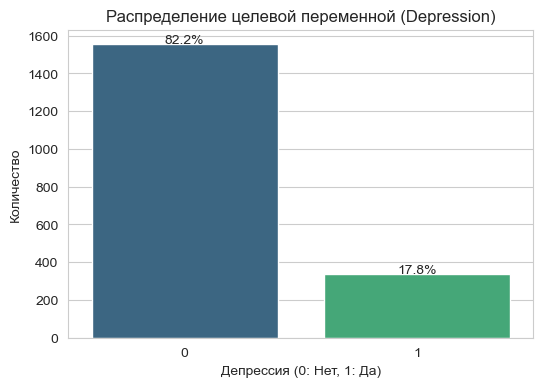

Точные пропорции:
Depression
0    0.821787
1    0.178213
Name: proportion, dtype: float64


In [178]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=y, palette='viridis')
plt.title('Распределение целевой переменной (Depression)')
plt.xlabel('Депрессия (0: Нет, 1: Да)')
plt.ylabel('Количество')

total = len(y)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3,
            f'{height/total*100:.1f}%', ha="center")

plt.show()

print("Точные пропорции:")
print(y.value_counts(normalize=True))

In [179]:
# Пропуски в Train
missing_train = train_df.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
missing_train_percent = (missing_train / len(train_df)) * 100
missing_info_train = pd.DataFrame({'Пропущено': missing_train, '%': missing_train_percent})

print(missing_info_train)

                    Пропущено          %
Academic Pressure        1509  79.799048
CGPA                     1509  79.799048
Study Satisfaction       1509  79.799048
Profession                511  27.022739
Work Pressure             382  20.200952
Job Satisfaction          382  20.200952


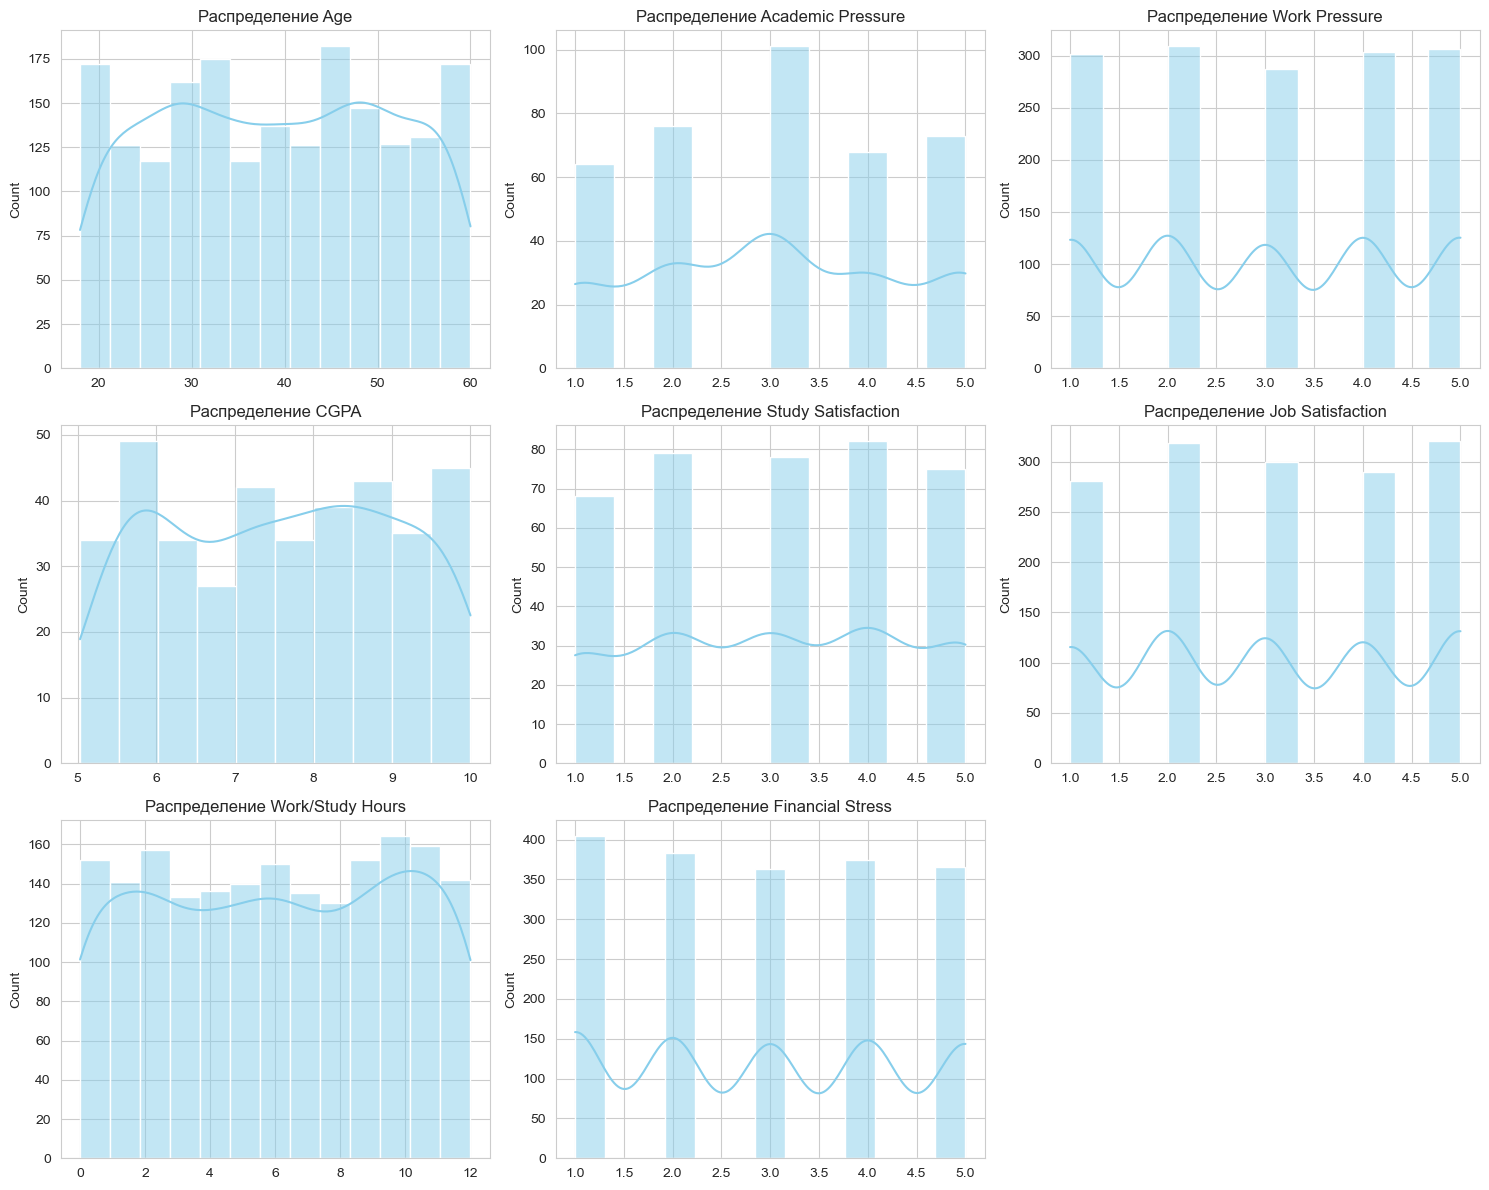

/var/folders/ls/btrdy60n12n_lk3plpt7wqlh0000gn/T/ipykernel_13055/2433857989.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='Depression', y=col, ax=axes[i], palette='viridis')
/var/folders/ls/btrdy60n12n_lk3plpt7wqlh0000gn/T/ipykernel_13055/2433857989.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='Depression', y=col, ax=axes[i], palette='viridis')
/var/folders/ls/btrdy60n12n_lk3plpt7wqlh0000gn/T/ipykernel_13055/2433857989.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x='Depr

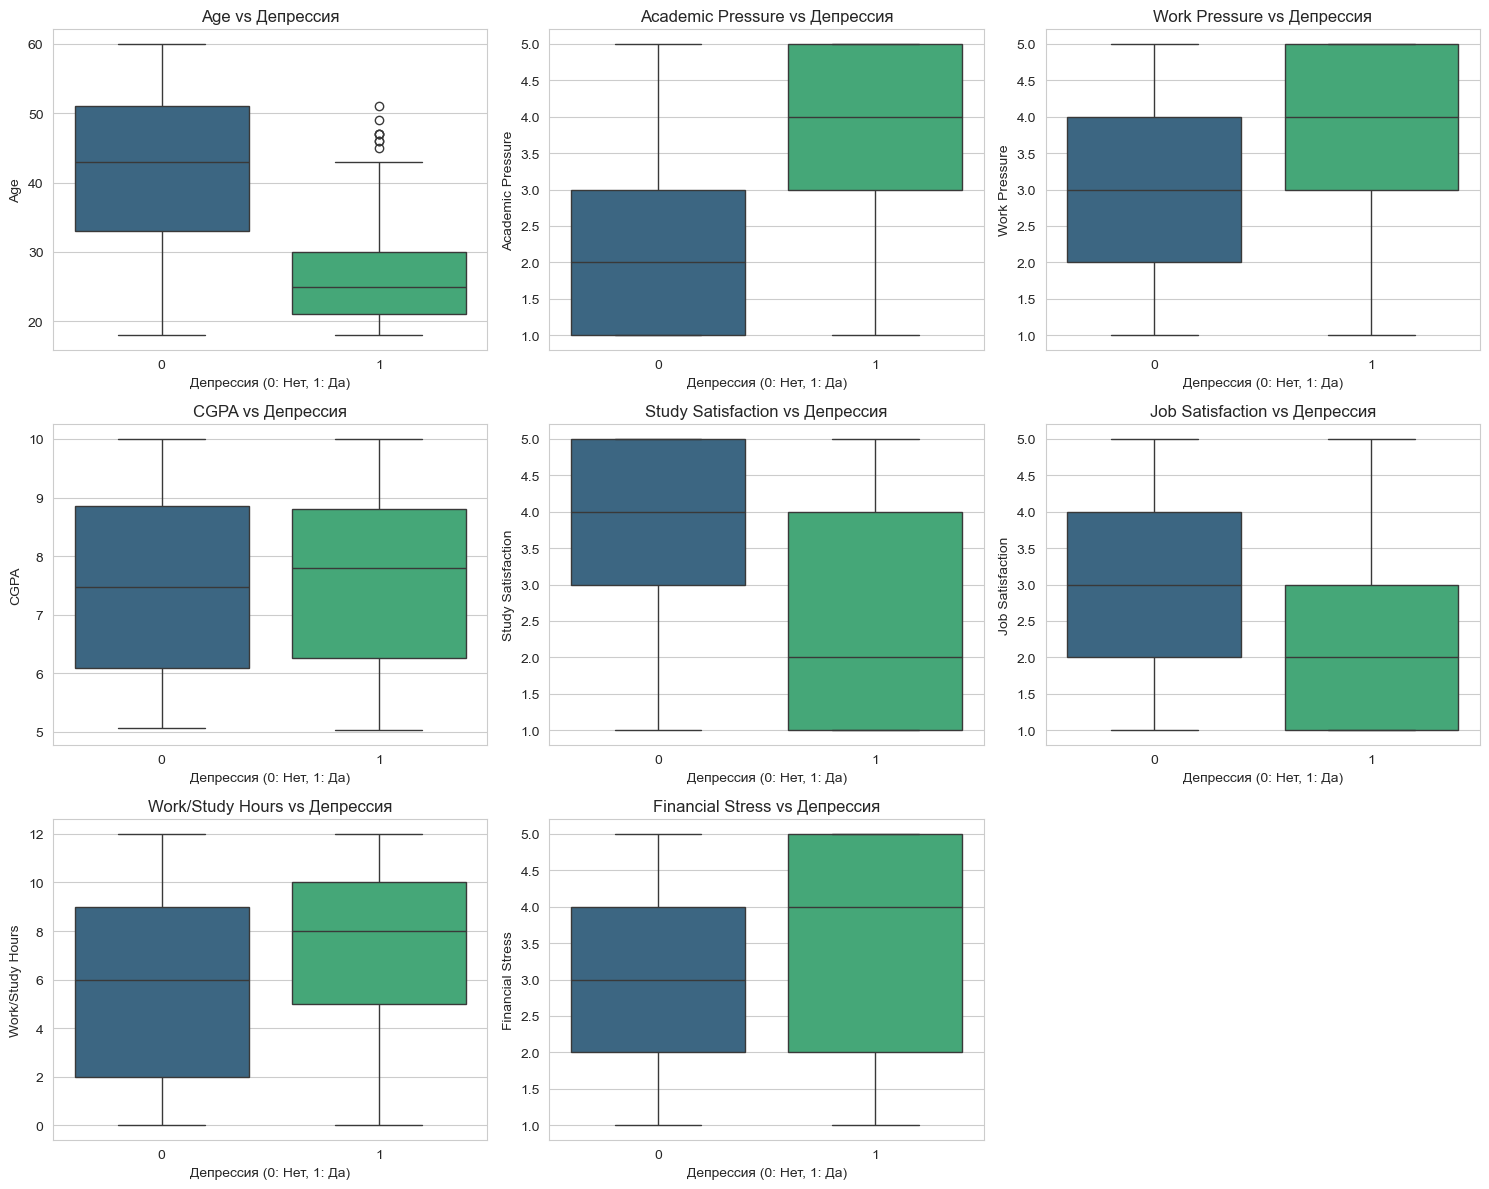

In [180]:
# Используем исходный train_df для анализа до преобразований
numerical_features_plot = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                           'Study Satisfaction', 'Job Satisfaction',
                           'Work/Study Hours', 'Financial Stress']

n_cols = 3
n_rows = (len(numerical_features_plot) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numerical_features_plot):
    sns.histplot(data=train_df, x=col, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel('')

# Удаление пустых сабплотов
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numerical_features_plot):
    sns.boxplot(data=train_df, x='Depression', y=col, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{col} vs Депрессия')
    axes[i].set_xlabel('Депрессия (0: Нет, 1: Да)')
    axes[i].set_ylabel(col)

# Удаление пустых сабплотов
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [181]:
# Вывод столбцов и колисество значений с ними
cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()


cat_stats = pd.DataFrame({
    'Column': cat_cols,
    'Unique_Count': [train_df[col].nunique() for col in cat_cols],
    'Unique_Values': [train_df[col].unique() for col in cat_cols]
})

cat_stats = cat_stats.sort_values(by='Unique_Count', ascending=False)
print(cat_stats[['Column', 'Unique_Count']])

                                  Column  Unique_Count
3                             Profession            35
1                                   City            30
6                                 Degree            27
4                         Sleep Duration             4
5                         Dietary Habits             3
0                                 Gender             2
2        Working Professional or Student             2
7  Have you ever had suicidal thoughts ?             2
8       Family History of Mental Illness             2


In [182]:
# Ячейка: Определение списков признаков (ID: f0d4b486)

# Числовые признаки
numerical_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                      'Study Satisfaction', 'Job Satisfaction',
                      'Work/Study Hours', 'Financial Stress']

# Категориальные признаки для OHE (мало уникальных)
categorical_features_ohe = ['Gender', 'Working Professional or Student',
                            'Dietary Habits',
                            'Have you ever had suicidal thoughts ?',
                            'Family History of Mental Illness'] # City, Profession, Degree убраны

# Категориальные признаки для Target Encoding (много уникальных)
categorical_features_target = ['City', 'Profession', 'Degree']

# Порядковые признаки
categorical_features_ordinal = ['Sleep Duration']

/var/folders/ls/btrdy60n12n_lk3plpt7wqlh0000gn/T/ipykernel_13055/3807662136.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, y=col, ax=axes[i], order=order, palette='magma')
/var/folders/ls/btrdy60n12n_lk3plpt7wqlh0000gn/T/ipykernel_13055/3807662136.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, y=col, ax=axes[i], order=order, palette='magma')
/var/folders/ls/btrdy60n12n_lk3plpt7wqlh0000gn/T/ipykernel_13055/3807662136.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, y=col, ax=a

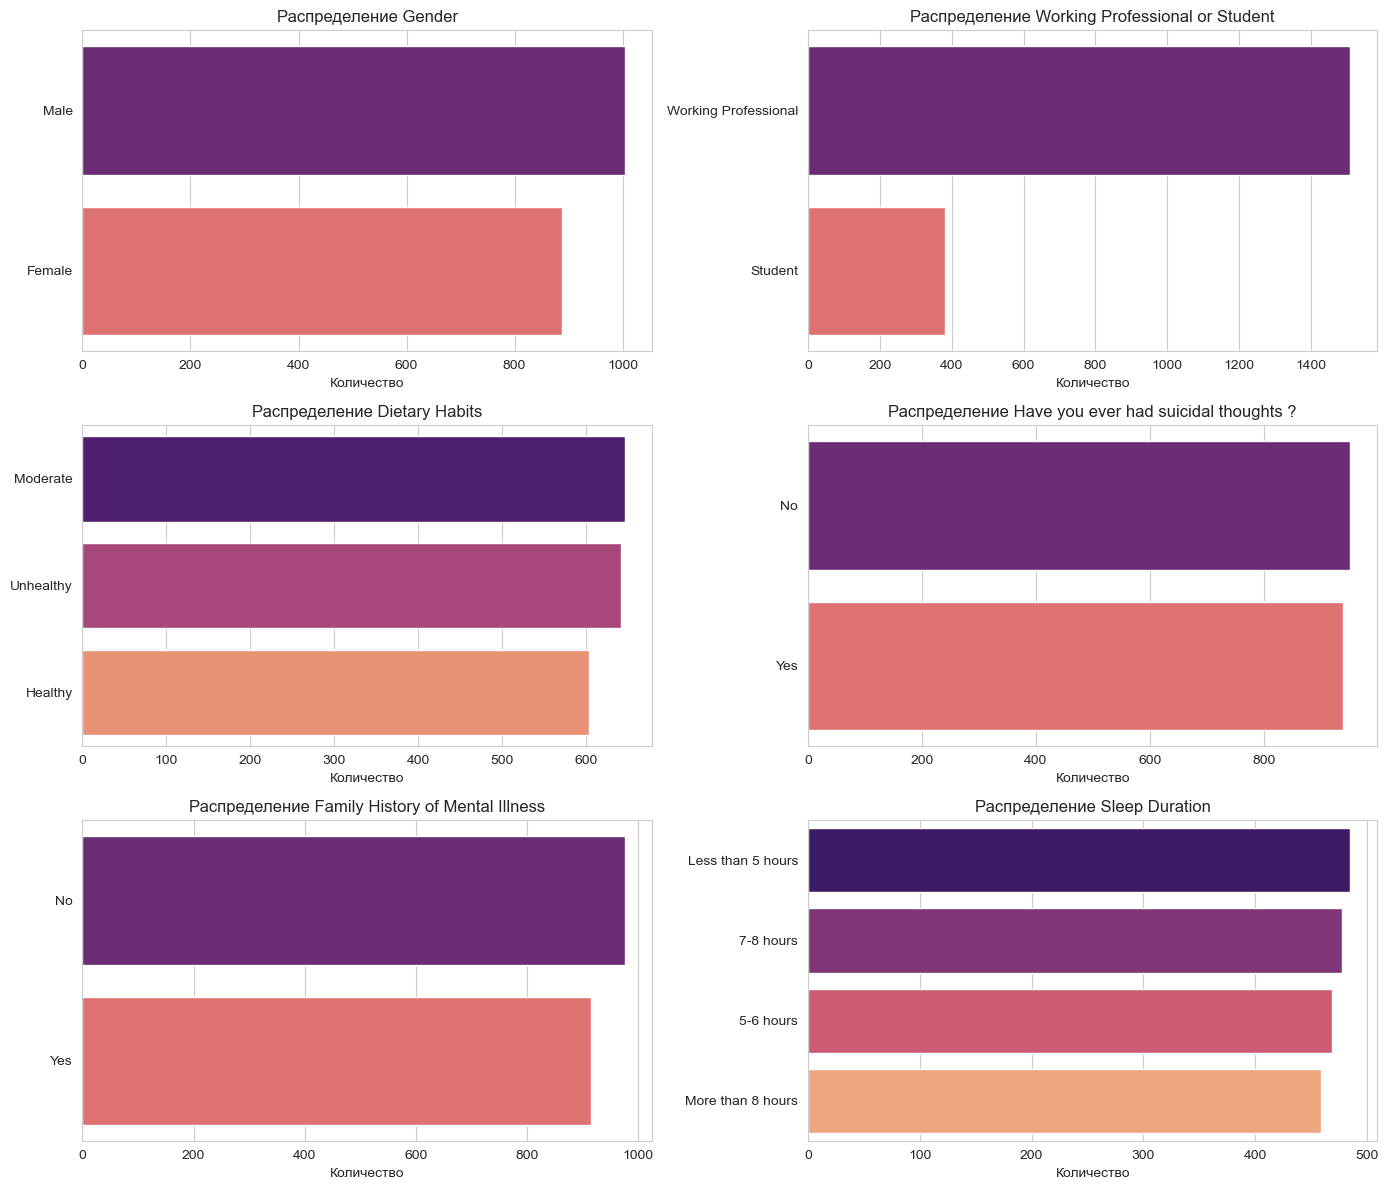

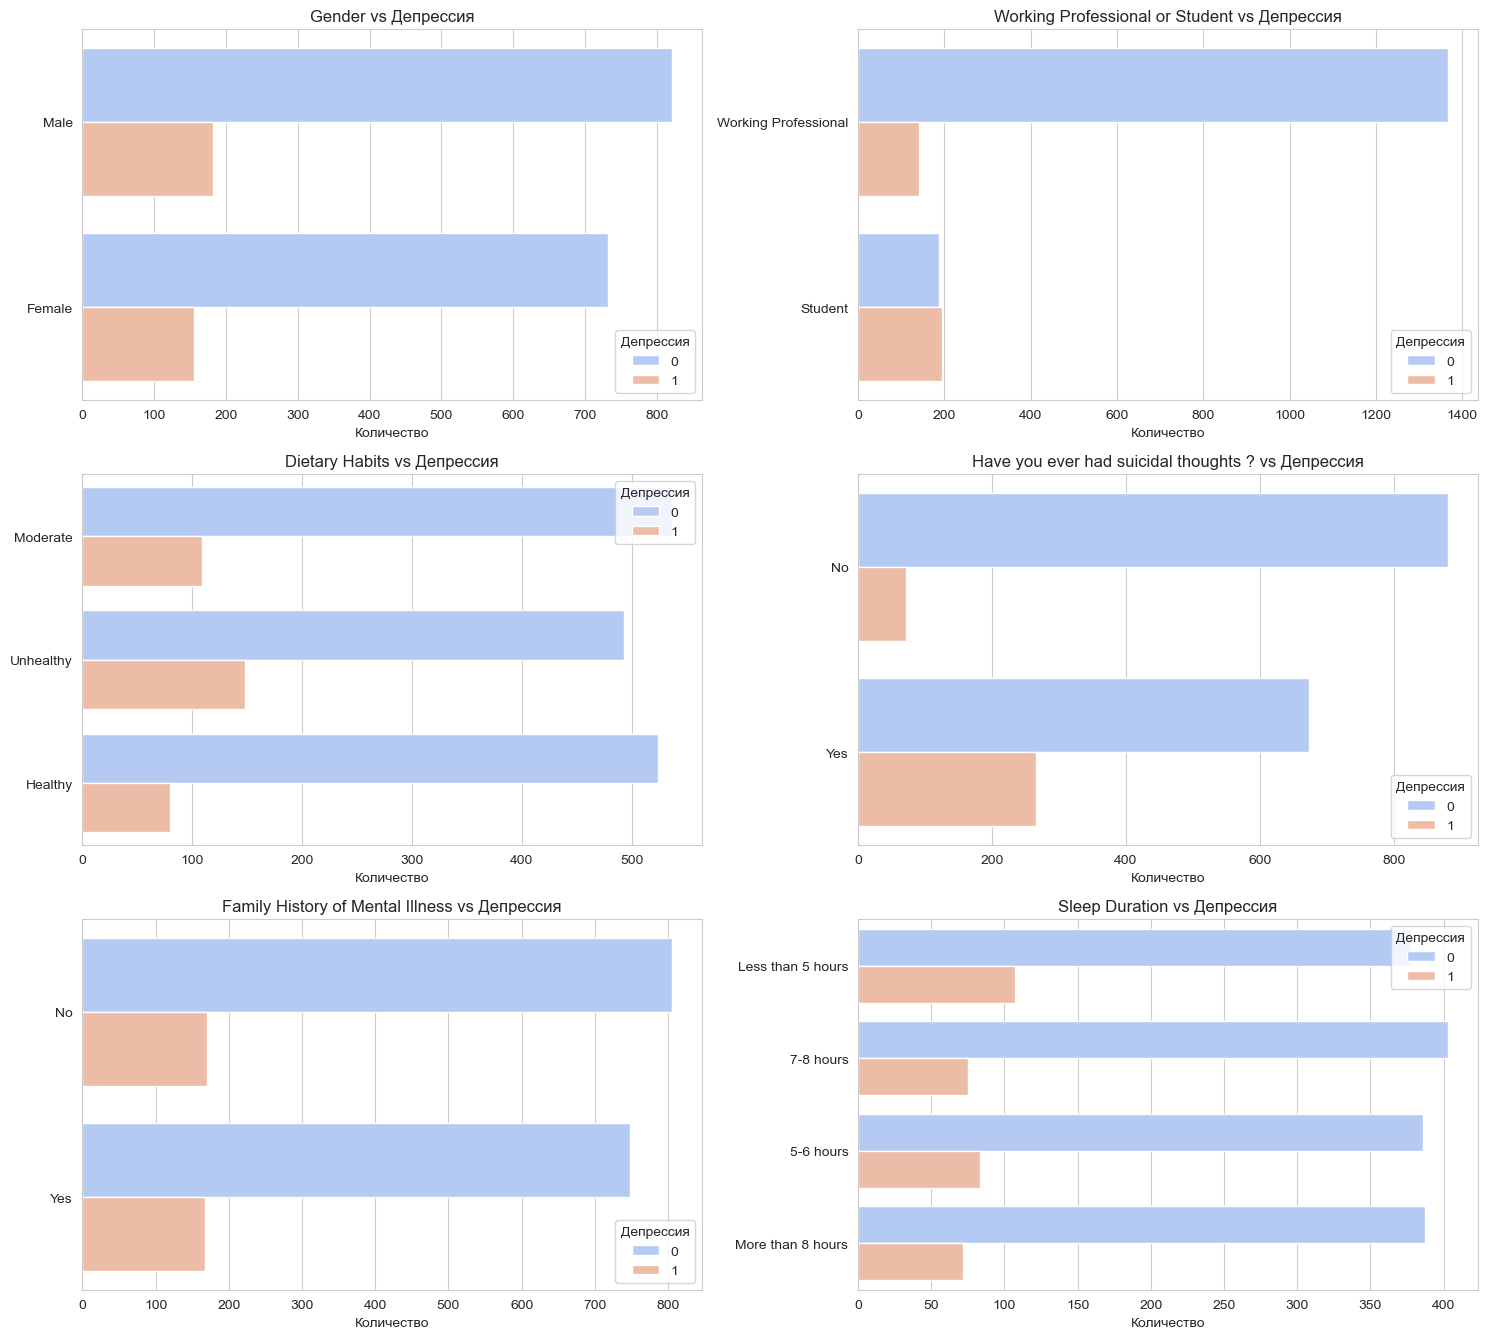

In [183]:
categorical_features_plot = ['Gender', 'City', 'Working Professional or Student',
                             'Profession', 'Dietary Habits', 'Degree',
                             'Have you ever had suicidal thoughts ?',
                             'Family History of Mental Illness', 'Sleep Duration']

# Разделяем на признаки с низкой и высокой кардинальностью для удобства визуализации
low_cardinality_features = [col for col in categorical_features_plot if train_df[col].nunique() < 15]
high_cardinality_features = [col for col in categorical_features_plot if train_df[col].nunique() >= 15]


n_cols = 2
n_rows_low = (len(low_cardinality_features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows_low, n_cols, figsize=(14, n_rows_low * 4))
axes = axes.flatten()

for i, col in enumerate(low_cardinality_features):
    order = train_df[col].value_counts().index # Сортировка по частоте
    sns.countplot(data=train_df, y=col, ax=axes[i], order=order, palette='magma')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel('Количество')
    axes[i].set_ylabel('')

# Удаление пустых сабплотов
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



fig, axes = plt.subplots(n_rows_low, n_cols, figsize=(15, n_rows_low * 4.5)) # Немного выше
axes = axes.flatten()

for i, col in enumerate(low_cardinality_features):
    order = train_df[col].value_counts().index
    sns.countplot(data=train_df, y=col, hue='Depression', ax=axes[i], order=order, palette='coolwarm') # Другая палитра
    axes[i].set_title(f'{col} vs Депрессия')
    axes[i].set_xlabel('Количество')
    axes[i].set_ylabel('')
    axes[i].legend(title='Депрессия')

# Удаление пустых сабплотов
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
()
plt.show()

In [184]:
# Конвейер для числовых признаков: Заполнение + Масштабирование
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)), 
    ('scaler', StandardScaler())
])

# Конвейер для категориальных с малым числом уникальных
ohe_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Конвейер для категориальных с большим числом уникальных
target_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('target', TargetEncoder(smoothing=15.0, 
                             handle_unknown='value', 
                             handle_missing='value')) 
])


sleep_order = ['Less than 5 hours', '5-6 hours', '7-8 hours', 'More than 8 hours'] 
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('ordinal', OrdinalEncoder(categories=[sleep_order]))
])

# передает нужные столбцы в соответствующие конвейеры
preprocessor_target_enc = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features), # Числовые
        ('ohe', ohe_transformer, categorical_features_ohe), # Категориальные (OHE)
        ('target', target_transformer, categorical_features_target), # Категориальные (Target)
        ('ord', ordinal_transformer, categorical_features_ordinal) # Порядковые
    ],
    remainder='passthrough'
)

preprocessor_target_enc # Показать структуру препроцессора

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'Academic Pressure', 'Work Pressure',
                                  'CGPA', 'Study Satisfaction',
                                  'Job Satisfaction', 'Work/Study Hours',
                                  'Financial Stress']),
                                ('ohe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('target',
                                                  TargetEncoder(smoothing=15.0))]),
                                 ['City', 'Profession', 'Degree']),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Less '
                                                                              'than '
                                                                              '5 '
                                                                              'hours',
                                                                              '5-6 '
                                                                              'hours',
                                                                              '7-8 '
                                                                              'hours',
                                                                              'More '
                                                                              'than '
                                                                              '8 '
                                                                              'hours']]))]),
                                 ['Sleep Duration'])])

In [185]:
# Итоговый конвейер
model_logreg_target = Pipeline(steps=[('preprocessor', preprocessor_target_enc),
                                       ('classifier', LogisticRegression(
                                           random_state=42,
                                           class_weight='balanced',
                                           C=2.0,               
                                           solver='lbfgs',      
                                           max_iter=1000,
                                       ))
                                      ])

print("Обучение...")
model_logreg_target.fit(X, y)
print("Обучение завершено")



print("Оценка на обучающих данных:")
y_pred_train_logreg_target = model_logreg_target.predict(X) # Предсказания
train_f1_logreg_target = f1_score(y, y_pred_train_logreg_target) # F1-мера
print(train_f1_logreg_target)

Обучение...
Обучение завершено
Оценка на обучающих данных:
0.9533239038189534


In [ ]:
# from sklearn.svm import SVC

# model_svc_target = Pipeline(steps=[('preprocessor', preprocessor_target_enc),
#                                     ('classifier', SVC( # Используем SVC
#                                         random_state=42,
#                                         class_weight='balanced', 
#                                         C=1.0, 
#                                                 
#                                         kernel='rbf', 
#                                         gamma='scale', 
#                                         probability=True
#                                     ))
#                                    ])


# model_svc_target.fit(X, y)

# y_pred_train_svc_target = model_svc_target.predict(X)
# train_f1_svc_target = f1_score(y, y_pred_train_svc_target)
# print(f"Train F1 (SVC): {train_f1_svc_target:.4f}")

Обучение SVC...
Обучение SVC завершено за 0.20 сек

Оценка SVC на обучающих данных:
Train F1 (SVC): 0.8904


In [187]:
test_predictions_logreg_target = model_logreg_target.predict(X_test)

submission_df_logreg_target = pd.DataFrame({'id': test_ids, 'Depression': test_predictions_logreg_target})
submission_df_logreg_target['Depression'] = submission_df_logreg_target['Depression'].astype(int)


submission_filename_logreg_target = 'submission_logreg_target_enc.csv' # New filename
submission_df_logreg_target.to_csv(submission_filename_logreg_target, index=False)


print("Первые 5 строк файла:")
print(submission_df_logreg_target.head())

Первые 5 строк файла:
   id  Depression
0   1           0
1   2           0
2   3           0
3   4           1
4   5           1
